In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
path = r"C:\Users\athen\Documents\GitHub\QTA_Spring2025\Final\api_based\song_clean.csv"
df = pd.read_csv(path)
df = df.drop(columns=['lyrics'])
df.head

<bound method NDFrame.head of                          title                                     artist  \
0                       Smooth               Santana Featuring Rob Thomas   
1                  Back At One                             Brian McKnight   
2     I Wanna Love You Forever                            Jessica Simpson   
3         My Love Is Your Love                            Whitney Houston   
4           I Knew I Loved You                              Savage Garden   
...                        ...                                        ...   
5975                   Dessert                                      Dawin   
5976             Backroad Song                              Granger Smith   
5977                    Random                                     G-Eazy   
5978                     Sorry            Rick Ross Featuring Chris Brown   
5979                  Drifting  G-Eazy Featuring Chris Brown & Tory Lanez   

      year                                   

In [29]:
# Check genres to see if it should be main focus
#Unknown Genres
unknown_count = (df['genre'].str.lower() == 'unknown').sum()
print(f"Unknown genre count: {unknown_count}")

#Drop unknowns and create strings
genre_series = df['genre'].dropna().str.lower()
genre_series = genre_series[genre_series != 'unknown']

#Deal with multiple genres
genre_split = genre_series.str.split(', ')
genre_exploded = genre_split.explode()

#Count genres
genre_counts = genre_exploded.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

#Display top genres
print("\nTop 15 genres:")
print(genre_counts.head(15))
df.head

#Chose to not as unknowns are a good amount; will maybe look into it for further analysis
# Create subset with known genres
df_with_genre = df[~df['genre'].isin(['Unknown', '', None])].copy()



Unknown genre count: 1585

Top 15 genres:
                Genre  Count
0             country    956
1    acoustic country    324
2                 r&b    270
3           christmas    254
4                 rap    168
5             hip hop    159
6                rock    152
7         post-grunge    144
8   alternative metal    117
9    southern hip hop    113
10                pop    103
11           pop punk     96
12           neo soul     91
13                emo     87
14           nu metal     81


In [30]:
# EDA of Spanish Songs
spanish_keywords = [
    'amor', 'corazón', 'beso', 'bailar', 'cielo', 'noche', 'día',
    'vida', 'latina', 'reggaeton', 'fiesta', 'cantar', 'mamí', 'mi amor',
    'contigo', 'latino', 'ven', 'quiero', 'baila', 'dame', 'morena', 'rico']

pattern = re.compile(r'\b(?:' + '|'.join(spanish_keywords) + r')\b', flags=re.IGNORECASE)

# Apply the regex to count Spanish keywords
def is_spanish(lyrics, threshold=2):
    if pd.isna(lyrics):
        return False
    matches = pattern.findall(lyrics.lower())
    return len(matches) >= threshold

# Apply the function
df['is_spanish'] = df['lyrics_clean'].apply(is_spanish)

# Show updated counts
print("Spanish:", df['is_spanish'].sum())
print("Non-Spanish:", (~df['is_spanish']).sum())
english_df = df[df['is_spanish'] == False].copy()

Spanish: 86
Non-Spanish: 5894


## Topic Modelling

In [31]:
# PRE PROCESSING
#setting stopwords and lemmitization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
custom_stopwords = set([ 
    'yeah', 'yea', 'yo', 'uh', 'uhh', 'uhm', 'uhhuh', 'huh', 'ha', 
    'haha', 'hee', 'nah', 'na', 'la', 'oo', 'ooh', 'ah', 'aah', 'whoa', 'woo', 'woah',
    'nigga', 'shit', 'fuck', 'fucking', 'bitch', 'ass', 'hoe', 'damn',
    'im', 'ive', 'ill', 'youre', 'youve', 'youll', 'dont', 'cant', 'wont', 
    'didnt', 'couldnt', 'shouldnt', 'aint', 'lets','baby', 'girl', 'boy', 'man', 
    'woman', 'thing', 'love', 'heart', 'mind', 'song', 'dance', 'feel', 'make', 'take', 
    'got', 'gonna', 'one', 'see', 'say', 'let', 'come', 'back',
    'hey', 'right', 'time', 'cause', 'wanna', 'gon', 'thats', 'new',
    'make', 'wont', 'need', 'want', 'never', 'little', 'away', 'thing',
    'oh', 'yeah', 'feel', 'life', 'way', 'night', 'day'
    'get', 'go', 'like', 'know', 'get','nana', 'lala', 'yeah', 'woo', 'dada',
    'woo', 'woohoo', 'mmm', 'mmmmm', 'la', 'lala', 'lalala', 
    'blah', 'blahblah', 'uh', 'ah', 'ooh', 'whoa', 'hey', 'ho'])
all_stopwords = stop_words.union(custom_stopwords)


def clean_lyrics(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)

    #Remove overused filler sounds (ooh, ayy, laaa, etc.)
    text = re.sub(r'\b(?:o+)+h*\b', '', text)  # ooh, ohhh
    text = re.sub(r'\b(?:a+)+y+\b', '', text)  # ayy, ayyy
    text = re.sub(r'\b(?:la+)+\b', '', text)   # laaa, lala

    #Normalize repetitive expressions
    text = re.sub(r'(na\s*){2,}', 'nana ', text)
    text = re.sub(r'(yeah\s*){2,}', 'yeah ', text)
    text = re.sub(r'(woo\s*){2,}', 'woo ', text)
    text = re.sub(r'(la\s*){2,}', 'lala ', text)
    text = re.sub(r'(da\s*){2,}', 'dada ', text)
    text = re.sub(r'\b(nana|yeah|woo|lala|dada)\b(\s+\1)+', r'\1', text)

    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    #Tokenize
    words = text.split()

    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words
        and word not in custom_stopwords
        and len(word) > 2]

    return " ".join(words)


#Apply to English songs
english_df['lyrics_clean_final'] = english_df['lyrics_clean'].apply(clean_lyrics)

In [32]:
# VECTORIZING

vectorizer = CountVectorizer(
    stop_words=list(all_stopwords),
    ngram_range=(1, 1),       
    min_df=10,                # common words
    max_df=0.9)                # rare words

dtm = vectorizer.fit_transform(english_df['lyrics_clean_final'])
tf_feature_names = vectorizer.get_feature_names_out()


In [33]:
# LDA
lda = LatentDirichletAllocation(n_components=12, random_state=37)
lda.fit(dtm)


LatentDirichletAllocation(n_components=12, random_state=37)

In [34]:
# TABLE 1
# Themes
topic_themes = {
    0: "Party & Club Vibes",
    1: "Love, Trust & Emotional Tension",
    2: "Reflective / Searching for Meaning",
    3: "Romantic Encounters & Anticipation",
    4: "Power, Ego & Provocative Energy",
    5: "Heartache & Vulnerability",
    6: "Missing Someone / Longing",
    7: "Energy & Escapism",
    8: "Dreams & Idealism",
    9: "Sensual & Intimate Moments",
    10: "Movement & Confidence",
    11: "Streetwise Attitude & Bragging"}

topic_values = lda.transform(dtm)
english_df['dominant_topic'] = topic_values.argmax(axis=1)

#loop to print and display table
for topic_num, topic in enumerate(lda.components_):
    print(f"\nTopic {topic_num + 1} — {topic_themes.get(topic_num, 'No Theme')}:")
    top_words = [tf_feature_names[i] for i in topic.argsort()[-10:][::-1]]
    print("Top words:", " | ".join(top_words))

    top_songs_df = english_df[english_df['dominant_topic'] == topic_num]

    if not top_songs_df.empty:
        sample_size = min(3, len(top_songs_df))
        top_songs = top_songs_df.sample(sample_size, random_state=1)

        for _, row in top_songs.iterrows():
            print(f" - {row['title']} by {row['artist']}")
    else:
        print(" - No songs found for this topic.")



Topic 1 — Party & Club Vibes:
Top words: stop | rock | party | music | keep | dem | said | ima | sing | goin
 - On The Ocean by K'Jon
 - House Of The Rising Sun by Kimberly Nichole
 - Dark Fantasy by Kanye West Featuring Teyana Taylor, Nicki Minaj & Bon Iver

Topic 2 — Love, Trust & Emotional Tension:
Top words: could | name | call | lie | tell | money | think | even | gotta | made
 - Opposite Of Adults by Chiddy Bang
 - Cooler Than Me by Mike Posner
 - I Know by Sunday

Topic 3 — Reflective / Searching for Meaning:
Top words: still | high | live | good | god | well | matter | side | old | road
 - Latch by Disclosure Featuring Sam Smith
 - Get Used To It by Justin Bieber
 - All Over The Road by Easton Corbin

Topic 4 — Romantic Encounters & Anticipation:
Top words: tonight | give | bit | wait | freak | babe | try | yes | left | gotta
 - Happy by Ashanti
 - Unbreakable by Alicia Keys
 - Letting Go (Dutty Love) by Sean Kingston Featuring Nicki Minaj

Topic 5 — Power, Ego & Provocative E

In [35]:
english_df.head

<bound method NDFrame.head of                          title                                     artist  \
0                       Smooth               Santana Featuring Rob Thomas   
1                  Back At One                             Brian McKnight   
2     I Wanna Love You Forever                            Jessica Simpson   
3         My Love Is Your Love                            Whitney Houston   
4           I Knew I Loved You                              Savage Garden   
...                        ...                                        ...   
5975                   Dessert                                      Dawin   
5976             Backroad Song                              Granger Smith   
5977                    Random                                     G-Eazy   
5978                     Sorry            Rick Ross Featuring Chris Brown   
5979                  Drifting  G-Eazy Featuring Chris Brown & Tory Lanez   

      year                                   

## Sentiment Analysis

In [36]:
# RUNNING Sentiment Analysis
sia = SentimentIntensityAnalyzer()
english_df['sentiment_scores'] = english_df['lyrics_clean_final'].apply(lambda x: sia.polarity_scores(str(x)))

#Dictionary Organization
sentiment_df = english_df['sentiment_scores'].apply(pd.Series)
english_df = pd.concat([english_df, sentiment_df], axis=1)

#Label
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

english_df['sentiment_label'] = english_df['compound'].apply(classify_sentiment)


C:\Users\athen\AppData\Local\Temp\ipykernel_3856\4228518922.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=english_df, x='sentiment_label', palette=custom_palette)


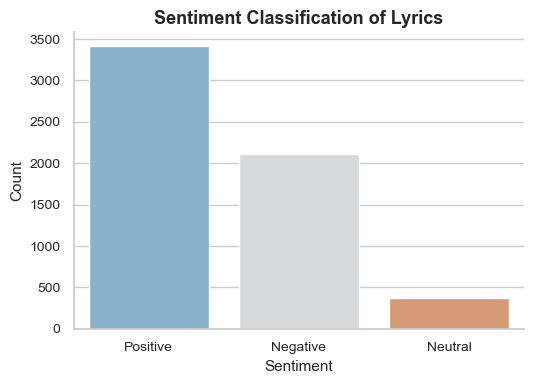

In [37]:
# FIGURE 1
# Distribution of Sentiment Labels
sns.set_theme(style="whitegrid")
custom_palette = ['#7FB3D5', '#D5D8DC', '#E59866']  # Positive, Negative, Neutral

#Plot
plt.figure(figsize=(5.5, 4))
sns.countplot(data=english_df, x='sentiment_label', palette=custom_palette)
plt.title('Sentiment Classification of Lyrics', fontsize=13, fontweight='bold')
plt.xlabel('Sentiment', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.tight_layout()

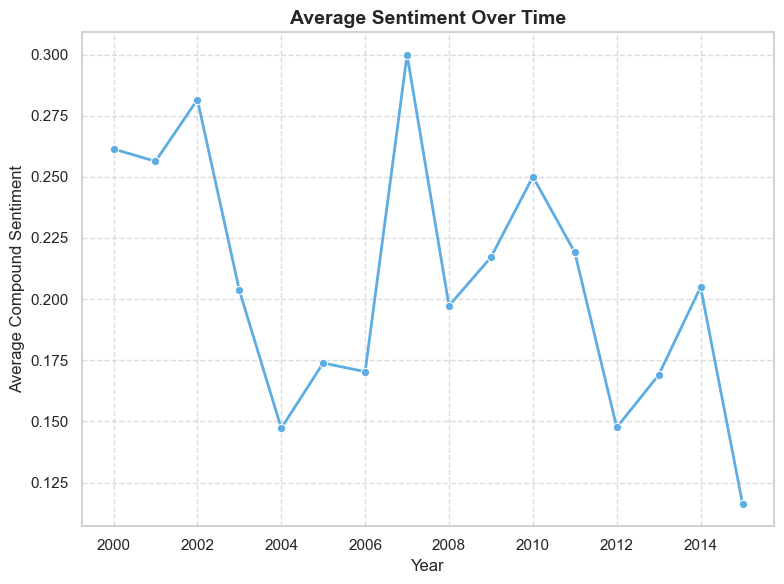

In [38]:
# FIGURE 5
# Sentiment by Year
avg_sentiment_by_year = english_df.groupby('year')['compound'].mean().reset_index()

#Plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=avg_sentiment_by_year,
    x='year',
    y='compound',
    marker='o',
    linewidth=2,
    color='#5DADE2')
plt.title('Average Sentiment Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Compound Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Topic vs. Sentiment

<Figure size 1000x550 with 0 Axes>

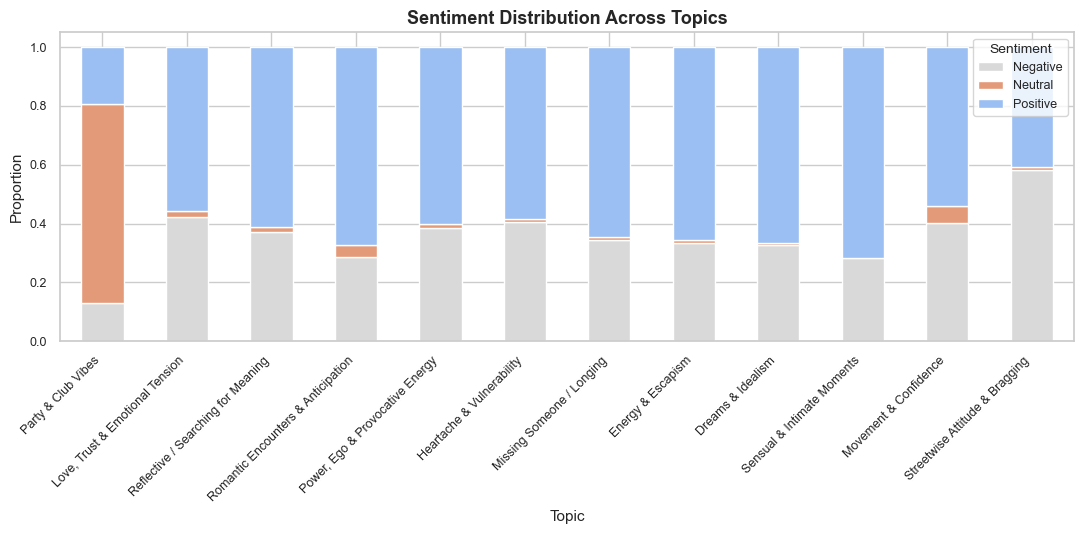

In [39]:
# FIGURE 2

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5.5))

#Define the crosstab
topic_sentiment_ct = pd.crosstab(
    english_df['dominant_topic'],
    english_df['sentiment_label'],
    normalize='index')
topic_sentiment_ct.index = topic_sentiment_ct.index.map(topic_themes)

#Plot
sentiment_colors = {
    'Positive': '#9BBFF2',  
    'Neutral': '#E39A78',  
    'Negative': '#D9D9D9'}
topic_sentiment_ct[["Negative", "Neutral", "Positive"]].plot(
    kind='bar',
    stacked=True,
    figsize=(11, 5.5),
    color=[sentiment_colors['Negative'], sentiment_colors['Neutral'], sentiment_colors['Positive']])
plt.title("Sentiment Distribution Across Topics", fontsize=13, fontweight='bold')
plt.xlabel("Topic", fontsize=11)
plt.ylabel("Proportion", fontsize=11)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title="Sentiment", fontsize=9, title_fontsize=10)
plt.tight_layout()

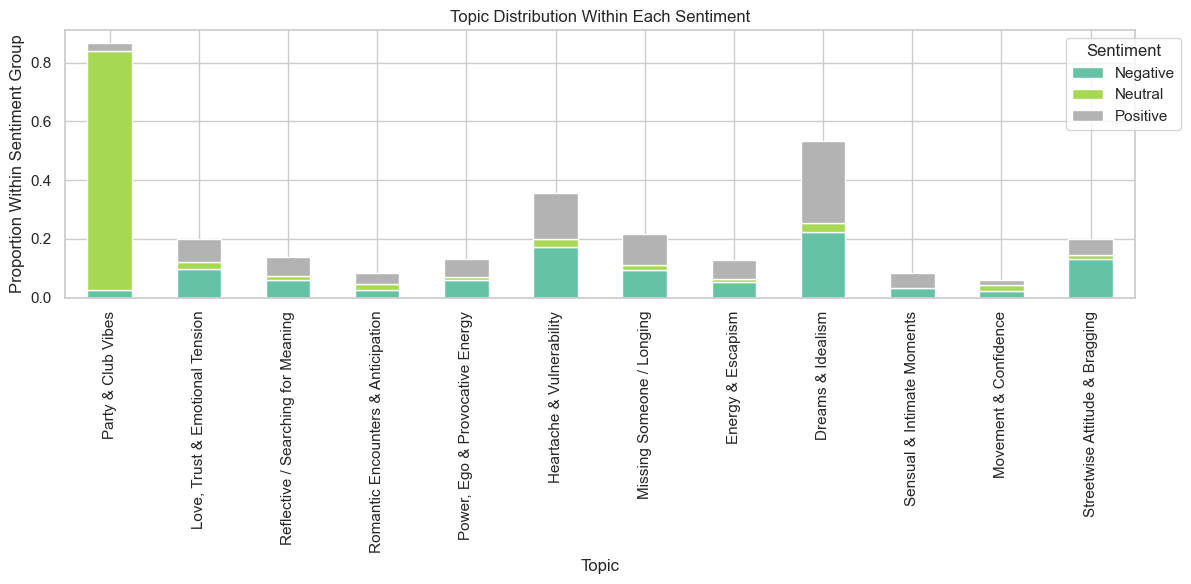

In [40]:
# Topics dominating Sentiment Group
sentiment_topic_ct = pd.crosstab(english_df['sentiment_label'], english_df['dominant_topic'], normalize='index')
sentiment_topic_ct.columns = sentiment_topic_ct.columns.map(topic_themes)

# Plot
sentiment_topic_ct.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Topic Distribution Within Each Sentiment")
plt.xlabel("Topic")
plt.ylabel("Proportion Within Sentiment Group")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Using Sentiment for Topic Modelling

In [41]:
# RUNNING Sentiment-Specific Topic Modelling
positive_themes = {
    0: "Swagger & Hype Energy",
    1: "Optimism & Light",
    2: "Love & Waiting",
    3: "Fun, Fame & Social Buzz",
    4: "Sensuality & Confidence",
    5: "Friendship, Reassurance & Beauty"}

negative_themes = {
    0: "Stress, Confusion & Burnout",
    1: "Hustle & Confrontation",
    2: "Street Talk & Bravado",
    3: "Club Vibes & Seduction",
    4: "Heartache & Disconnection",
    5: "Nostalgia & Longing"}

positive_table = []
negative_table = []

#Loop through data and run LDA
for label in ['Positive', 'Negative']:
    theme_dict = positive_themes if label == 'Positive' else negative_themes
    subset = english_df[english_df['sentiment_label'] == label]
    #VECTORIZING
    vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
    dtm = vectorizer.fit_transform(subset['lyrics_clean_final'])
    tf_feature_names = vectorizer.get_feature_names_out()
    #LDA
    lda = LatentDirichletAllocation(n_components=6, random_state=42)
    topic_values = lda.fit_transform(dtm)

    subset = subset.copy()
    subset['dominant_topic'] = topic_values.argmax(axis=1)
    
    topic_counts = subset['dominant_topic'].value_counts().sort_index()
    total = topic_counts.sum()
    #LABELLING
    for topic_num, topic in enumerate(lda.components_):
        top_words = [tf_feature_names[i] for i in topic.argsort()[-10:][::-1]]
        percent = round((topic_counts.get(topic_num, 0) / total) * 100, 1)
        row = {
            'Topic #': f"Topic {topic_num + 1}",
            'Theme': theme_dict[topic_num],
            '% of Songs': percent,
            'Top Words': ", ".join(top_words)}
        if label == 'Positive':
            positive_table.append(row)
        else:
            negative_table.append(row)

positive_df = pd.DataFrame(positive_table)
negative_df = pd.DataFrame(negative_table)

print("\nPositive Sentiment Topics")
print(positive_df)

print("\nNegative Sentiment Topics")
print(negative_df)



Positive Sentiment Topics
   Topic #                             Theme  % of Songs  \
0  Topic 1             Swagger & Hype Energy        13.8   
1  Topic 2                  Optimism & Light        21.6   
2  Topic 3                    Love & Waiting        29.6   
3  Topic 4           Fun, Fame & Social Buzz         7.0   
4  Topic 5           Sensuality & Confidence        10.2   
5  Topic 6  Friendship, Reassurance & Beauty        17.8   

                                           Top Words  
0  rock, hand, hot, money, beat, work, club, ima,...  
1  tonight, good, light, day, dream, fall, eye, l...  
2  shes, think, said, home, day, long, gone, thin...  
3  party, girl, world, run, live, okay, look, peo...  
4  better, touch, body, think, bring, yes, try, f...  
5  tell, gotta, alright, friend, good, best, beau...  

Negative Sentiment Topics
   Topic #                        Theme  % of Songs  \
0  Topic 1  Stress, Confusion & Burnout        11.7   
1  Topic 2       Hustle & Conf

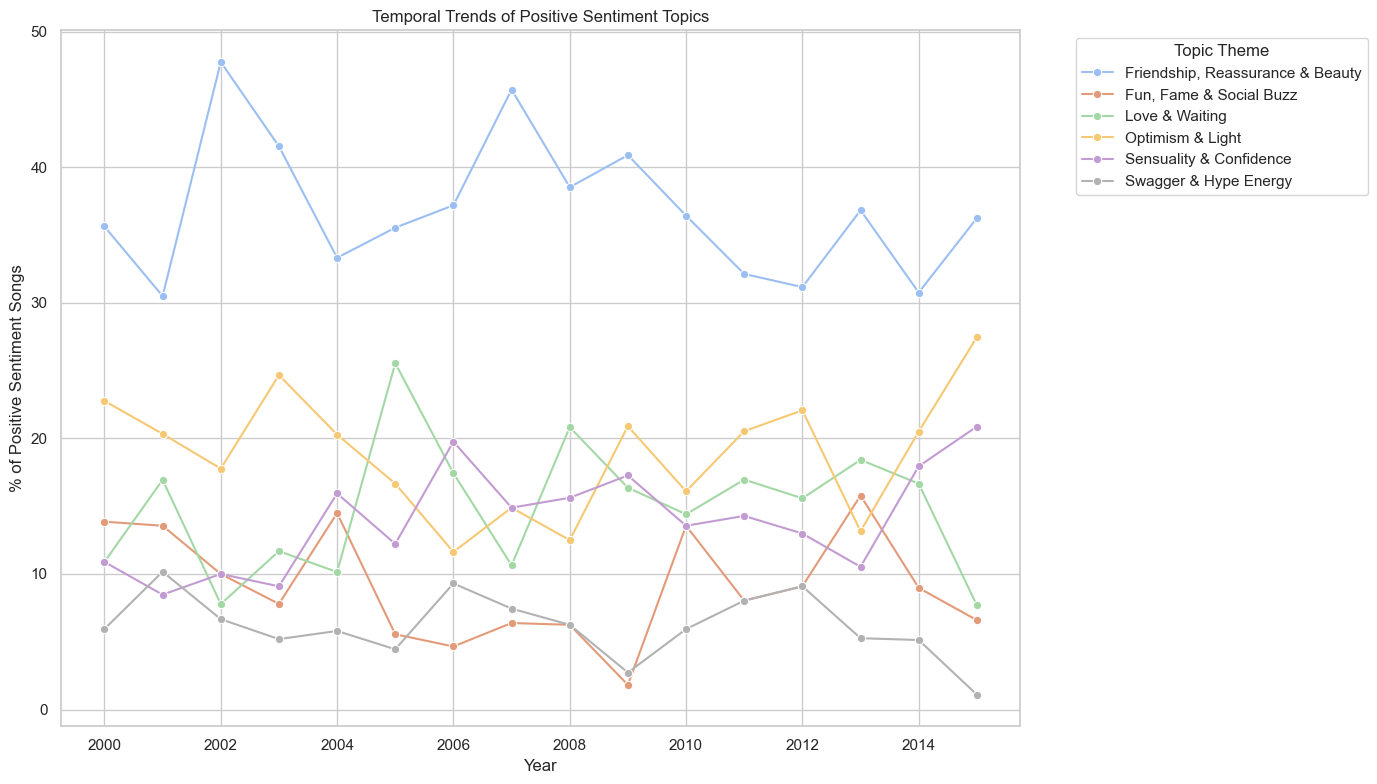

In [42]:
# FIGURE 3
custom_palette = {
    "Friendship, Reassurance & Beauty": "#9BBFF2", 
    "Fun, Fame & Social Buzz": "#E39A78",      
    "Love & Waiting": "#A3D8A5",                    
    "Optimism & Light": "#F7C873",                  
    "Sensuality & Confidence": "#C39BD3",           
    "Swagger & Hype Energy": "#B2B2B2"}

#Data Work
positive_df = english_df[english_df['sentiment_label'] == 'Positive'].copy()
positive_df['topic_theme'] = positive_df['dominant_topic'].map(positive_themes)
topic_counts_by_year = positive_df.groupby(['year', 'topic_theme']).size().reset_index(name='count')
total_counts_by_year = topic_counts_by_year.groupby('year')['count'].transform('sum')
topic_counts_by_year['percentage'] = topic_counts_by_year['count'] / total_counts_by_year * 100

#Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=topic_counts_by_year,
    x='year',
    y='percentage',
    hue='topic_theme',
    marker='o',
    palette=custom_palette)
plt.title('Temporal Trends of Positive Sentiment Topics')
plt.xlabel('Year')
plt.ylabel('% of Positive Sentiment Songs')
plt.legend(title='Topic Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


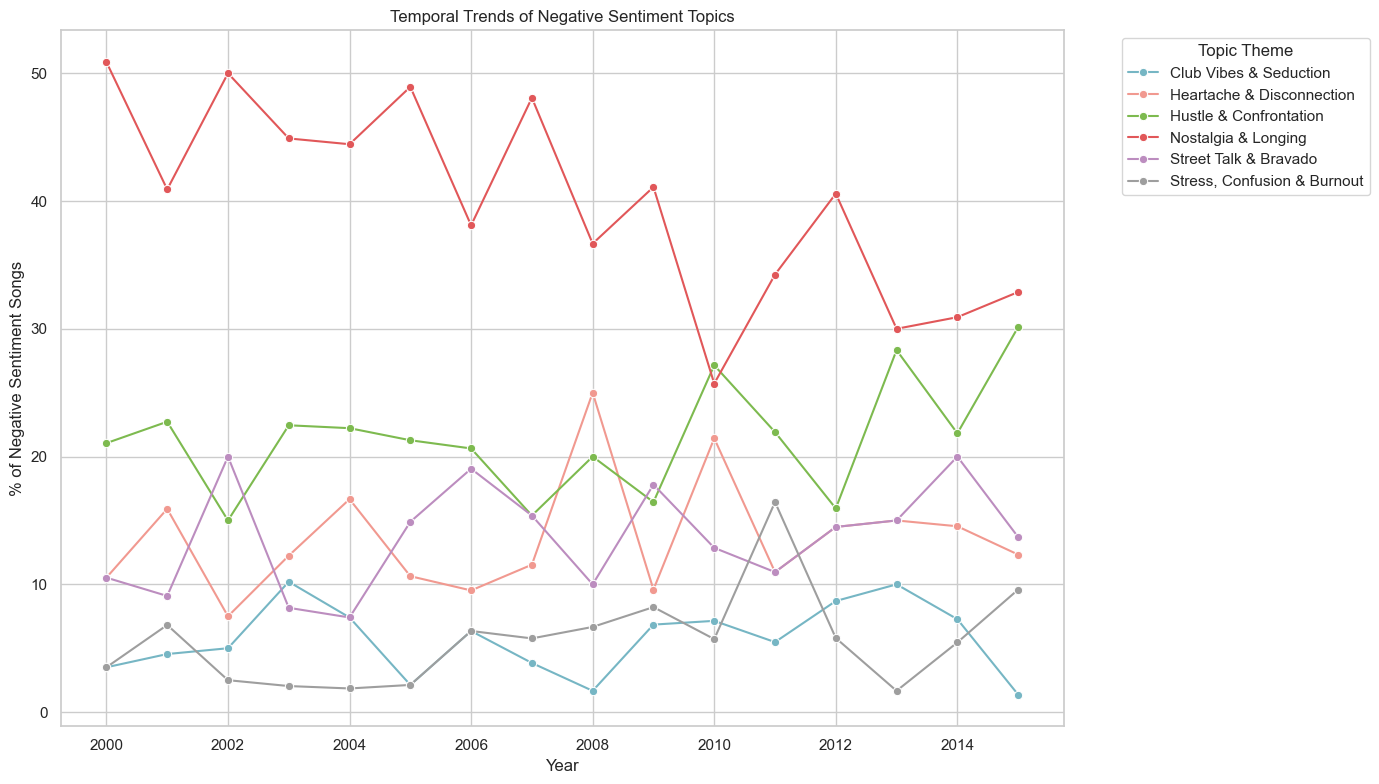

In [43]:
# FIGURE 4
negative_palette = {
    "Club Vibes & Seduction": "#76B6C4",        
    "Heartache & Disconnection": "#F19990",      
    "Hustle & Confrontation": "#7DBA4F",          
    "Nostalgia & Longing": "#E15759",           
    "Street Talk & Bravado": "#BC8DBF",        
    "Stress, Confusion & Burnout": "#9E9E9E"}

#Data Work
negative_df = english_df[english_df['sentiment_label'] == 'Negative'].copy()
negative_df['topic_theme'] = negative_df['dominant_topic'].map(negative_themes)
neg_topic_counts_by_year = negative_df.groupby(['year', 'topic_theme']).size().reset_index(name='count')
neg_total_counts_by_year = neg_topic_counts_by_year.groupby('year')['count'].transform('sum')
neg_topic_counts_by_year['percentage'] = neg_topic_counts_by_year['count'] / neg_total_counts_by_year * 100

#Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=neg_topic_counts_by_year,
    x='year',
    y='percentage',
    hue='topic_theme',
    marker='o',
    palette=negative_palette)
plt.title('Temporal Trends of Negative Sentiment Topics')
plt.xlabel('Year')
plt.ylabel('% of Negative Sentiment Songs')
plt.legend(title='Topic Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
